In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import numpy as np
import re
#pd.set_option('display.max_rows', 100)
from IPython.display import display

# load league data

In [2]:
def read_league_data(file="2017-summer-match-data-OraclesElixir-2017-08-07.csv",path="C:/Users/joey_/__notebooks__/_python/LoL_game_prediction/",delim=','):
    return convert_leaguenames(pd.read_csv(path+file, encoding = "ISO-8859-1",delimiter=delim))
    
def round_weeks(data):
    try:
        data.loc[:,"week"] = data["week"].astype(np.double).round()
    except ValueError:
        data.loc[:,"week"] = pd.to_numeric(data["week"],errors="coerce").round()
    data = data.dropna(subset=["week"])
    return data

def iter_weeks(data):
    for indexes, df in data.groupby("week"):
        yield df

def iter_games(data):
    data = data.set_index(["week","gameid","game","split"]) # weird bug where sometimes gameid is not unique
    for indexes, df in data.groupby(level=["week","gameid","game","split"]):
        yield df.reset_index()

#input a gameDF and a teamDF   
def add_players(game,team):
    game = game.reset_index().set_index(["team","playerid"])
    players = game.xs(team["team"],level="team")
    players = players.drop(team.name)
    newcols = pd.Series(players["champion"].values,players["position"].values)
    team = team.append(newcols)
    return team.to_frame().T
    
def summarize_game(game):
    game = game.set_index(["playerid"])
    team1 = game.xs(100)#level=["playerid"]
    team2 = game.xs(200)#,level=["playerid"]
    teamnames = sorted([str(team1["team"]), str(team2["team"])])
    versus = teamnames[0] + "~" + teamnames[1]
    print(versus)
    matchup_series = pd.Series([versus],index=["matchup"])
    team1 = pd.concat([team1,matchup_series],ignore_index=False)
    team1.name = 100
    team2 = pd.concat([team2,matchup_series],ignore_index=False)
    team2.name = 200
    #team1.set_value("matchup",versus) -- so much slower
    #team2 = team2.set_value("matchup", versus) -- so much slower
    team1 = add_players(game,team1)
    team2 = add_players(game,team2)
    team1 = add_opp_stats(team1,team2)
    team2 = add_opp_stats(team2,team1)
    return team1, team2

def summarize_all_games(league):
    all_games = []
    for game in iter_games(league):
        #print(game)
        teams = summarize_game(game)
        all_games.append(teams[0])
        all_games.append(teams[1])
    return pd.concat(all_games)

def add_opp_stats(team,opp, features=["cspm","dmgtochamps","dmgtochampsperminute","earnedgpm","team",'wards','wardkills']):
    #'cspm' 'dmgtochamps' 'dmgtochampsperminute' 'earnedgpm'
    newcols = opp[features]
    newcols = newcols.add_prefix("opp_")
    team = pd.concat([team,newcols],axis=1)
    return team

def assign_matches(league):
    #league['week'].astype(str) + 
    #league['date'].dt.weekday_name + league['date'].dt.month.astype(str)
    league.loc[:,"matchID"] = ( league['date'].astype(str) + league['matchup'].str.strip() + league["league"] + league["split"].astype(str)).astype('category').cat.codes
    league = set_unique_gameid(league)
    league = league.sort_values(['week','matchID'],ascending=True)
    league = league.set_index(['team','week','matchID','game'])
    for indexes, df in league.groupby(level=['team']):
        league.loc[df.index.values,'team_match_num'] = pd.Series(df.index.get_level_values('matchID')).astype('category').cat.codes.values
        league.loc[df.index.values,'team_game_num'] = (pd.Series(df.index.get_level_values('matchID')).astype('str') + pd.Series(df.index.get_level_values('game')).astype('str')).astype('category').cat.codes.values
    return league.reset_index()

def set_match_wins(league):
    league = league.set_index(["matchID","gameid2","team"]) #unique IDs
    '''
    _ = league.groupby(level=["matchID","team"])['result'].sum()
    print(_.index)
    stop
    print(league.loc[(slice(None), _.index)])
    print(league.loc[_.index,:])
    stop
    league.loc[_.index, 'matchResult'] = (_.values > 1).astype(int)
    '''
    for indexes, df in league.groupby(level=["matchID","team"]):
        #print(indexes)
        league.loc[df.index,"matchResult"] = int(df["result"].sum() > 1)
    return league.reset_index()

def set_unique_gameid(leagues):
    leagues.loc[:,'gameid2'] =(leagues['matchID'].astype(str) + '_' + leagues['game'].astype(str) + '_' + leagues['week'].astype(str)+ '_' + leagues['split'].astype(str)+ '_' + leagues['league'].astype(str)).astype('category').cat.codes
    return leagues

def process_league(data, league="NALCS", summarize=True, set_matches=False, k=20, split="2017-1"):
    lg = data.loc[data["league"] == league.upper()]
    lg = round_weeks(lg)
    #lg = harmonize_teamnames(lg)
    lg.loc[:,"date"] = pd.to_datetime(lg["date"])
    lg.loc[:,"split"] = split
    if summarize:
        lg = summarize_all_games(lg)
        if set_matches:
            lg = assign_matches(lg)
            lg = set_match_wins(lg)
            lg = calculate_all_elo2(lg,k=k)
    return lg

def combine_leagues(leagues,set_matches=True,unify_names=True,k=20):
    leagues = pd.concat(leagues,sort=True)
    if set_matches:
        print("assigning matches...")
        leagues = assign_matches(leagues)
        print("seting match wins...")
        #leagues = set_match_wins(leagues)
        print("calculating elo...")
        leagues = calculate_all_elo2(leagues,k=k)
        print()
    if unify_names:
        process_teamnames(leagues,team_names_col='team')
        process_teamnames(leagues,team_names_col='opp_team')
        process_teamnames(leagues,team_names_col='matchup')
    return leagues

def expected(A, B):
    """
    Calculate expected score of A in a match against B
    :param A: Elo rating for player A
    :param B: Elo rating for player B
    """
    return 1 / (1 + 10 ** ((B - A) / 400))


def delta_elo(exp, score, k=32):
    """
    Calculate the new Elo rating for a player
    :param old: The previous Elo rating
    :param exp: The expected score for this match
    :param score: The actual score for this match
    :param k: The k-factor for Elo (default: 32)
    """
    return k * (score - exp)

'''
input team DFs for specific matchup
'''
def calculate_delta_elo(team1_elo, team2_elo, team1_result,k=20):
    e = expected(team1_elo,team2_elo)
    re = int(team1_result)
    dElo = delta_elo(e,re,k=k)
    return dElo

def get_prev_match_elo(team,league,teamname,matchnum):
    if matchnum > 0:
        index =(teamname,matchnum - 1)
        print(index)
    else:
        index = (teamname,matchnum)
    return league.at[index,'elo'][0]

def get_match_elo(team,league,teamname,matchnum):
    index = (teamname,matchnum)
    return league.at[index,'elo'][0]

def calculate_all_elo2(league,k=20):
    league.loc[:,'elo'] = 1600
    league = league.sort_values(by=['week','team_match_num'],ascending=True)
    teams = league['team'].unique()
    league = league.set_index(['gameid2','team'])
    elo_db = pd.Series([1600]*len(teams),index=teams)
    #count = 0
    for indexes, df in league.groupby(['week','gameid2','split']):
        #count += 1
        gameid = indexes[1]
        #get teams
        vs = df.index.get_level_values('team').values
        tm1 = vs[0]
        tm2 = vs[1]
        won = df.xs(tm1,level='team')['result'].values[0]
        
        #calculate elo
        tm1_elo = elo_db[tm1]
        tm2_elo = elo_db[tm2]
        dElo = calculate_delta_elo(tm1_elo, tm2_elo, won,k=20)
        
        #update elo
        tm1_elo += dElo
        tm2_elo -= dElo
        
        league.at[(gameid,tm1),'elo'] = tm1_elo
        league.at[(gameid,tm2),'elo'] = tm2_elo
        elo_db[tm1] = tm1_elo
        elo_db[tm2] = tm2_elo
        
    league = league.reset_index()
    return league
        
        #if count == 20:
            #print(league.loc[(gameid,tm1),'elo'])


def calculate_champion_elo(league,positions=['Support','Top','Middle','ADC','Jungle'],k=20):
    for pos in positions:
        print('position: ', pos)
        champions = league[pos].unique()
        elo_db = pd.Series([1600]*len(champions),index=champions)
        #league.loc[:,pos+'_elo'] = 1600
        league = league.sort_values(by=['week','team_match_num'],ascending=True)
        league = league.set_index([pos,'gameid2'])
        
        league = league.sort_index(level=league.index.names) # address performance warning
        for indexes, df in league.groupby(['week','matchID','gameid2','split']):
            champs = df.index.get_level_values(pos)
            #print(champs)
            champ_1_key = champs[0]
            champ_2_key = champs[1]
            champ1_win = df.iloc[0]['result']
            x = calculate_delta_elo(elo_db[champ_1_key],elo_db[champ_2_key],champ1_win)
            elo_db[champ_1_key] += x
            elo_db[champ_2_key] -= x
            league.at[(champ_1_key,indexes[2]),pos+'_elo'] = elo_db[champ_1_key]
            league.at[(champ_2_key,indexes[2]),pos+'_elo'] = elo_db[champ_2_key]
        league = league.reset_index()
    return league

def calculate_net_features(leagues,pairs=[('wards','wardkills','net_wards')],normalize=False):
    for pair in pairs:
        leagues.loc[:,pair[2]] = leagues.loc[:,pair[0]] - leagues.loc[:,pair[1]]
        if normalize:
            leagues = normalize_by_gamelength(leagues,pair[2])
    return leagues

def calculate_ward_score(leagues):
    '''
    ward_score = (wards - opp_wardkills) / (opp_wards - wardkills)
    
    if ward_score > 1: team has better vision
    if ward scare < 1: opp_team has better vision
    '''
    leagues = calculate_net_features(leagues,pairs=[('wards','opp_wardkills','net_wards')],normalize=True)
    leagues = calculate_net_features(leagues,pairs=[('opp_wards','wardkills','opp_net_wards')],normalize=True)
    leagues.loc[:,'vision_score'] = leagues['net_wards'] / leagues['opp_net_wards']
    return leagues
    
    
def normalize_by_gamelength(leagues,var,gamelength='gamelength'):
    leagues.loc[:,var+"_per_min"] = leagues.loc[:,var] / leagues[gamelength]
    return leagues


def calculate_draft_score(leagues,positions=['Support','Top','Middle','ADC','Jungle'],k=20,weights={'Support_elo' : 1,
                                                                                                   'Top_elo': 1,
                                                                                                   'Middle_elo' : 1,
                                                                                                   'ADC_elo' : 1,
                                                                                                   'Jungle_elo' : 1}):
    leagues = calculate_champion_elo(leagues,positions=positions)
    leagues.loc[:,'draft_score'] = leagues[list(weights.keys())].dot(list(weights.values())) / len(weights.values())
    return leagues
    
def calculate_secondary_features(leagues):
    leagues = calculate_ward_score(leagues)
    leagues = calculate_draft_score(leagues)
    leagues.loc[:,'kda'] = ((leagues['k'] + leagues['a']) / leagues['d']).replace([np.inf, -np.inf], np.nan)
    leagues.loc[:,'kda2'] = (leagues['k'] + leagues['a'] - leagues['d'])
    leagues.loc[:,'kda2_per_min'] = leagues.loc[:,'kda2']/leagues['gamelength']
    
    
    #calculate net_features 
    for f in ["cspm","dmgtochamps","dmgtochampsperminute","earnedgpm"]:
        leagues.loc[:,'net_'+f] = leagues.loc[:,f] - leagues.loc[:,'opp_'+f]
        
    leagues = one_hot_encode_categories(leagues)
    
    return leagues

def one_hot_encode_categories(df, features=['league','split'],return_new_cols=False):
    _ = pd.get_dummies(df[features])
    df = pd.concat([df,_],axis=1)
    if return_new_cols:
        return df, list(_.columns.values)
    else:
        return df
    #display(df)
    #stop
                

##### TO-DO: MAKE LEAGUE TEAM NAMES CONSISTENT WITHIN A LEAGUE ######
def process_teamnames(lg,team_names_col='team',drop_regex=[r'TEAM',r'GAMING',r'E-?SPORTS'],sub_regex={r'~ ' : '~', ' ~':'~'}):
    lg.loc[:,team_names_col] = lg[team_names_col].str.upper()
    for ex in drop_regex:
        lg.loc[:,team_names_col] = lg[team_names_col].str.replace(ex, '').str.strip()
    
    for ex in sub_regex.keys():
        to = sub_regex[ex]
        lg.loc[:,team_names_col] = lg[team_names_col].str.replace(ex, to).str.strip()
        #print(np.unique(lg[team_names_col]))
    return lg
        
def convert_leaguenames(df, leaguenames = {'LCS':'NALCS','LEC':'EULCS'}):
    for lg in leaguenames:
        df['league'] = df['league'].replace(lg,leaguenames[lg])
    return df
    
    
    
print("...done...") 

...done...


In [3]:
import copy
#'''

#'''


summer = read_league_data()
spring = read_league_data(file="2017-spring-match-data-OraclesElixir-2017-04-27.csv")
spring18 = read_league_data(file="2018-spring-match-data-OraclesElixir-2018-05-20.csv")
summer18 = read_league_data(file="2018_summer_match_data_OraclesElixir_2018-09-27.txt",delim="\t")
spring19 = read_league_data(file="2019-spring-match-data-OraclesElixir-2019-03-15.txt",delim="\t")

nasp17 = process_league(spring)
eusp17 = process_league(spring,league="EULCS")
lcksp17 = process_league(spring,league="LCK")
lmssp17 = process_league(spring,league='LMS')

nasu17 = process_league(summer,split="2017-2")
eusu17 = process_league(summer,league="EULCS",split="2017-2")
lcksu17 = process_league(summer,league="LCK",split="2017-2")
lmssu17 = process_league(summer,league='LMS',split='2017-2')

nasp18 = process_league(spring18,split="2018-1", league='NALCS')
eusp18 = process_league(spring18,split="2018-1", league='EULCS')
lcksp18 = process_league(spring18,split="2018-1", league='LCK')
lmssp18 = process_league(spring18,split='2018-1',league='LMS')

nasu18 = process_league(summer18,split="2018-2", league='NALCS')
eusu18 = process_league(summer18,split="2018-2", league='EULCS')
lcksu18 = process_league(summer18,split="2018-2", league='LCK')
lmssu18 = process_league(summer18,split='2018-2',league='LMS')

nasp19 = process_league(spring19,split="2019-1", league='NALCS')
eusp19 = process_league(spring19,split="2019-1", league='EULCS')
lcksp19 = process_league(spring19,split="2019-1", league='LCK')
lmssp19 = process_league(spring19,split='2019-1',league='LMS')

'''
'''
orig_leagues = combine_leagues([nasp17,eusp17,lcksp17,lmssp17,
                                nasu17,eusu17,lcksu17,lmssu17,
                                nasp18,eusp18,lcksp18,lmssp18,
                                nasu18,eusu18,lcksu18,lmssu18,
                                nasp19,eusp19,lcksp19,lmssp19],
                                set_matches=True) #lmssp18,lmssp17,lmssu17
#'''

leagues = copy.copy(orig_leagues)
leagues = calculate_secondary_features(leagues)

leagues.loc[leagues['game'] == 'T','game'] = 11


#remove_null_features(leagues[['elo','vision_score','draft_score','kda','kda2_per_min','kpm','gdat10','wards','wardkills']]
#'''    
print(leagues[["matchID","matchup","week","split",'team_match_num','elo']])

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (6,80) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (33,34,35,69) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\

EnVyUs~Flyquest
EnVyUs~Flyquest
Dignitas~Phoenix1
Dignitas~Phoenix1
Dignitas~Phoenix1
Counter Logic Gaming~EnVyUs
Immortals~Team SoloMid
Counter Logic Gaming~EnVyUs
Immortals~Team SoloMid
Flyquest~Team Liquid
Immortals~Team SoloMid
Cloud9~Dignitas
Flyquest~Team Liquid
Flyquest~Team Liquid
Cloud9~Dignitas
Cloud9~Dignitas
Cloud9~Team SoloMid
Cloud9~Team SoloMid
Echo Fox~Phoenix1
Echo Fox~Phoenix1
Counter Logic Gaming~Team Liquid
Counter Logic Gaming~Team Liquid
Echo Fox~Immortals
Echo Fox~Immortals
Echo Fox~Immortals
Counter Logic Gaming~Flyquest
Counter Logic Gaming~Flyquest
Dignitas~Team SoloMid
Dignitas~Team SoloMid
Dignitas~Team SoloMid
EnVyUs~Phoenix1
EnVyUs~Phoenix1
Dignitas~Echo Fox
Dignitas~Echo Fox
Dignitas~Echo Fox
Echo Fox~Flyquest
Phoenix1~Team Liquid
Echo Fox~Flyquest
Phoenix1~Team Liquid
Echo Fox~Flyquest
EnVyUs~Immortals
Cloud9~Counter Logic Gaming
EnVyUs~Immortals
Cloud9~Counter Logic Gaming
EnVyUs~Immortals
Cloud9~Counter Logic Gaming
Cloud9~Immortals
Cloud9~Immortals
Te

Afreeca Freecs~KT Rolster
Afreeca Freecs~KT Rolster
Afreeca Freecs~KT Rolster
BBQ Olivers~Kongdoo Monster
BBQ Olivers~Kongdoo Monster
Afreeca Freecs~Jin Air Green Wings
ROX Tigers~Samsung Galaxy
ROX Tigers~Samsung Galaxy
ROX Tigers~Samsung Galaxy
MVP~SK Telecom T1
MVP~SK Telecom T1
Afreeca Freecs~ROX Tigers
Afreeca Freecs~ROX Tigers
Kongdoo Monster~Samsung Galaxy
Kongdoo Monster~Samsung Galaxy
BBQ Olivers~Longzhu Gaming
Jin Air Green Wings~KT Rolster
Afreeca Freecs~SK Telecom T1
Longzhu Gaming~ROX Tigers
Longzhu Gaming~ROX Tigers
Longzhu Gaming~ROX Tigers
BBQ Olivers~SK Telecom T1
BBQ Olivers~SK Telecom T1
Jin Air Green Wings~MVP
Jin Air Green Wings~MVP
Jin Air Green Wings~MVP
Afreeca Freecs~ROX Tigers
BBQ Olivers~Longzhu Gaming
Jin Air Green Wings~KT Rolster
Kongdoo Monster~MVP
Kongdoo Monster~MVP
Kongdoo Monster~MVP
Afreeca Freecs~SK Telecom T1
KT Rolster~Samsung Galaxy
KT Rolster~Samsung Galaxy
KT Rolster~MVP
KT Rolster~MVP
Longzhu Gaming~SK Telecom T1
Longzhu Gaming~SK Telecom T1
L

Cloud9~Phoenix1
Cloud9~Phoenix1
EnVyUs~Immortals
EnVyUs~Immortals
Counter Logic Gaming~Echo Fox
Dignitas~Team SoloMid
Dignitas~Team SoloMid
Counter Logic Gaming~Echo Fox
Counter Logic Gaming~Echo Fox
Dignitas~Team SoloMid
EnVyUs~Team Liquid
FlyQuest~Immortals
EnVyUs~Team Liquid
FlyQuest~Immortals
EnVyUs~Team Liquid
FlyQuest~Immortals
Dignitas~Team Liquid
Cloud9~Echo Fox
Dignitas~Team Liquid
Cloud9~Echo Fox
Dignitas~Team Liquid
Counter Logic Gaming~Team SoloMid
FlyQuest~Phoenix1
Counter Logic Gaming~Team SoloMid
FlyQuest~Phoenix1
Counter Logic Gaming~Team SoloMid
Team Liquid~Team SoloMid
Team Liquid~Team SoloMid
Counter Logic Gaming~FlyQuest
Counter Logic Gaming~FlyQuest
Counter Logic Gaming~FlyQuest
Immortals~Team Liquid
Immortals~Team Liquid
Echo Fox~EnVyUs
Echo Fox~EnVyUs
Cloud9~Immortals
Cloud9~Immortals
Cloud9~Immortals
Dignitas~Phoenix1
Dignitas~Phoenix1
Dignitas~Phoenix1
Counter Logic Gaming~Phoenix1
EnVyUs~Team SoloMid
EnVyUs~Team SoloMid
Counter Logic Gaming~Phoenix1
Cloud9~Fly

Afreeca Freecs~BBQ Olivers
Afreeca Freecs~BBQ Olivers
Jin Air Green Wings~Longzhu Gaming
Jin Air Green Wings~Longzhu Gaming
Jin Air Green Wings~Longzhu Gaming
Ever8 Winners~SK Telecom T1
Ever8 Winners~SK Telecom T1
BBQ Olivers~ROX Tigers
BBQ Olivers~ROX Tigers
KT Rolster~MVP
KT Rolster~MVP
MVP~SK Telecom T1
MVP~SK Telecom T1
BBQ Olivers~Ever8 Winners
BBQ Olivers~Ever8 Winners
BBQ Olivers~Ever8 Winners
Afreeca Freecs~ROX Tigers
Afreeca Freecs~ROX Tigers
Afreeca Freecs~ROX Tigers
KT Rolster~Samsung Galaxy
KT Rolster~Samsung Galaxy
KT Rolster~Samsung Galaxy
Jin Air Green Wings~KT Rolster
Jin Air Green Wings~KT Rolster
Longzhu Gaming~ROX Tigers
Longzhu Gaming~ROX Tigers
Longzhu Gaming~MVP
Longzhu Gaming~MVP
BBQ Olivers~Jin Air Green Wings
BBQ Olivers~Jin Air Green Wings
MVP~ROX Tigers
MVP~ROX Tigers
BBQ Olivers~KT Rolster
BBQ Olivers~KT Rolster
Afreeca Freecs~SK Telecom T1
Afreeca Freecs~SK Telecom T1
Afreeca Freecs~SK Telecom T1
Ever8 Winners~Samsung Galaxy
Ever8 Winners~Samsung Galaxy
Ji

Cloud9~Echo Fox
100 Thieves~Team Liquid
FlyQuest~Golden Guardians
Echo Fox~Team SoloMid
100 Thieves~Cloud9
FlyQuest~OpTic Gaming
Counter Logic Gaming~Golden Guardians
Clutch Gaming~Team Liquid
Counter Logic Gaming~Echo Fox
Cloud9~OpTic Gaming
100 Thieves~Clutch Gaming
FlyQuest~Team Liquid
Golden Guardians~Team SoloMid
Echo Fox~OpTic Gaming
100 Thieves~Team SoloMid
Golden Guardians~Team Liquid
Cloud9~Clutch Gaming
Counter Logic Gaming~FlyQuest
Clutch Gaming~Team SoloMid
Cloud9~Team Liquid
Counter Logic Gaming~OpTic Gaming
100 Thieves~FlyQuest
Echo Fox~Golden Guardians
Cloud9~FlyQuest
100 Thieves~Golden Guardians
Counter Logic Gaming~Team SoloMid
Echo Fox~Team Liquid
Clutch Gaming~OpTic Gaming
Counter Logic Gaming~Team Liquid
100 Thieves~Echo Fox
Cloud9~Team SoloMid
Clutch Gaming~FlyQuest
Golden Guardians~OpTic Gaming
Clutch Gaming~Team SoloMid
Golden Guardians~Team Liquid
Cloud9~Echo Fox
100 Thieves~Counter Logic Gaming
FlyQuest~OpTic Gaming
100 Thieves~Cloud9
Clutch Gaming~Counter Logi

BBQ Olivers~KT Rolster
BBQ Olivers~KT Rolster
KSV Esports~SK Telecom T1
KSV Esports~SK Telecom T1
Kongdoo Monster~ROX Tigers
Kongdoo Monster~ROX Tigers
Afreeca Freecs~Kongdoo Monster
Afreeca Freecs~Kongdoo Monster
BBQ Olivers~Kingzone DragonX
BBQ Olivers~Kingzone DragonX
Kingzone DragonX~ROX Tigers
Kingzone DragonX~ROX Tigers
Kingzone DragonX~ROX Tigers
Jin Air Green Wings~KSV Esports
Jin Air Green Wings~KSV Esports
Jin Air Green Wings~KSV Esports
KT Rolster~MVP
KT Rolster~MVP
Afreeca Freecs~BBQ Olivers
KSV Esports~ROX Tigers
KSV Esports~ROX Tigers
KSV Esports~ROX Tigers
Jin Air Green Wings~Kingzone DragonX
Jin Air Green Wings~Kingzone DragonX
KSV Esports~Kingzone DragonX
KSV Esports~Kingzone DragonX
KSV Esports~Kingzone DragonX
Jin Air Green Wings~ROX Tigers
Jin Air Green Wings~ROX Tigers
Jin Air Green Wings~ROX Tigers
Afreeca Freecs~BBQ Olivers
BBQ Olivers~Kongdoo Monster
BBQ Olivers~Kongdoo Monster
MVP~SK Telecom T1
MVP~SK Telecom T1
Kongdoo Monster~SK Telecom T1
Kongdoo Monster~SK 

Griffin~Hanwha Life Esports
Gen.G~Kingzone DragonX
Gen.G~Kingzone DragonX
Gen.G~Kingzone DragonX
Afreeca Freecs~SK Telecom T1
Afreeca Freecs~SK Telecom T1
Jin Air Green Wings~KT Rolster
Jin Air Green Wings~KT Rolster
BBQ Olivers~Hanwha Life Esports
BBQ Olivers~Hanwha Life Esports
Griffin~MVP
Griffin~MVP
Afreeca Freecs~KT Rolster
Afreeca Freecs~KT Rolster
Afreeca Freecs~KT Rolster
BBQ Olivers~Griffin
BBQ Olivers~Griffin
BBQ Olivers~Griffin
Gen.G~MVP
Gen.G~MVP
Hanwha Life Esports~Jin Air Green Wings
Hanwha Life Esports~Jin Air Green Wings
Griffin~Jin Air Green Wings
Griffin~Jin Air Green Wings
MVP~SK Telecom T1
MVP~SK Telecom T1
MVP~SK Telecom T1
Gen.G~Hanwha Life Esports
Gen.G~Hanwha Life Esports
Gen.G~Hanwha Life Esports
Afreeca Freecs~Kingzone DragonX
Griffin~SK Telecom T1
Griffin~SK Telecom T1
Jin Air Green Wings~MVP
Jin Air Green Wings~MVP
KT Rolster~Kingzone DragonX
KT Rolster~Kingzone DragonX
Afreeca Freecs~BBQ Olivers
Afreeca Freecs~BBQ Olivers
Afreeca Freecs~Kingzone DragonX
Afr

Flash Wolves~G-Rex
J Team~Team Afro
J Team~Team Afro
J Team~Team Afro
Hong Kong Attitude~Machi 17
Cloud9~Team Liquid
100 Thieves~Team SoloMid
Counter Logic Gaming~OpTic Gaming
FlyQuest~Golden Guardians
Clutch Gaming~Echo Fox
FlyQuest~OpTic Gaming
100 Thieves~Cloud9
Counter Logic Gaming~Team Liquid
Clutch Gaming~Team SoloMid
Echo Fox~Golden Guardians
100 Thieves~Golden Guardians
Echo Fox~OpTic Gaming
Clutch Gaming~Team Liquid
FlyQuest~Team SoloMid
Cloud9~Counter Logic Gaming
Echo Fox~Team SoloMid
Cloud9~Golden Guardians
100 Thieves~Team Liquid
Counter Logic Gaming~FlyQuest
Clutch Gaming~OpTic Gaming
100 Thieves~Clutch Gaming
FlyQuest~Team Liquid
Cloud9~Team SoloMid
Counter Logic Gaming~Echo Fox
Golden Guardians~OpTic Gaming
Echo Fox~FlyQuest
Cloud9~Clutch Gaming
OpTic Gaming~Team Liquid
Golden Guardians~Team SoloMid
100 Thieves~Counter Logic Gaming
OpTic Gaming~Team SoloMid
Golden Guardians~Team Liquid
Cloud9~Echo Fox
100 Thieves~FlyQuest
Clutch Gaming~Counter Logic Gaming
100 Thieves~E

Dragon Gate Team~G-Rex
Dragon Gate Team~Flash Wolves
Hong Kong Attitude~MAD Team
Hong Kong Attitude~MAD Team
Alpha Esports~MAD Team
Alpha Esports~MAD Team
Alpha Esports~MAD Team
Hong Kong Attitude~J Team
Hong Kong Attitude~J Team
Hong Kong Attitude~J Team
G-Rex~MAD Team
G-Rex~MAD Team
G-Rex~MAD Team
Dragon Gate Team~J Team
Dragon Gate Team~J Team
Dragon Gate Team~Hong Kong Attitude
Dragon Gate Team~Hong Kong Attitude
AHQ e-Sports Club~Flash Wolves
AHQ e-Sports Club~Flash Wolves
Alpha Esports~Flash Wolves
Alpha Esports~Flash Wolves
G-Rex~Hong Kong Attitude
G-Rex~Hong Kong Attitude
G-Rex~Hong Kong Attitude
J Team~MAD Team
J Team~MAD Team
J Team~MAD Team
AHQ e-Sports Club~Alpha Esports
AHQ e-Sports Club~Alpha Esports
AHQ e-Sports Club~Alpha Esports
AHQ e-Sports Club~Dragon Gate Team
AHQ e-Sports Club~Dragon Gate Team
AHQ e-Sports Club~Dragon Gate Team
Flash Wolves~G-Rex
Flash Wolves~G-Rex
Flash Wolves~G-Rex
Alpha Esports~G-Rex
Alpha Esports~G-Rex
Dragon Gate Team~MAD Team
Dragon Gate Team

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


seting match wins...
calculating elo...

position:  Support
position:  Top
position:  Middle
position:  ADC
position:  Jungle
      matchID                               matchup  week   split  \
0        1214                        ECHO FOX~OPTIC   8.0  2018-2   
1        1241     JIN AIR GREEN WINGS~SK TELECOM T1   1.0  2019-1   
2        1242                         AHQ  CLUB~MAD   1.0  2019-1   
3        1267           KT ROLSTER~KINGZONE DRAGONX   2.0  2019-1   
4        1292                   HANWHA LIFE~SANDBOX   2.0  2019-1   
5        1303                        DAMWON~SANDBOX   3.0  2019-1   
6        1303                        DAMWON~SANDBOX   3.0  2019-1   
7        1305                 GRIFFIN~SK TELECOM T1   3.0  2019-1   
8        1321                             G2~SPLYCE   3.0  2019-1   
9        1322                       GRIFFIN~SANDBOX   3.0  2019-1   
10       1332                          EXCEL~FNATIC   4.0  2019-1   
11       1337                    100 THIEVES~C

In [98]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler

def read_summary_data(path="C:\\Users\\joey\\__Notebooks__\\python notebooks\\LoL_game_prediction\\",file="eu_nalcs_2017.csv"):
    return pd.read_csv(path+file)
    
def convert_to_numeric(df):
    return df.apply(pd.to_numeric,args=('ignore',))

def numeric_columns(df,not_numeric=False,
                    exceptions=["odds","gameid",'gameid2',"week","date","game","patchno","champion","matchID","matchResult"]): #"csat10","csdat10","cssharepost15","dmgshare","doubles","earnedgoldshare","monsterkillsenemyjungle","oppcsat10","pentas","quadras","triples","ADC_champ_strength","Jungle_champ_strength","Middle_champ_strength","Support_champ_strength","Top_champ_strength"
    to_remove=[]
    for e in exceptions:
        print(e," ", ((e in list(df.columns.values)) == False))
        if (e in list(df.columns.values)) == False:
            to_remove.append(e)
    for e in to_remove:
        exceptions.remove(e)
    df = convert_to_numeric(df)
    ax = 0
    df = df.drop(exceptions, axis=1)
    if not_numeric:
        result = list(df.select_dtypes(exclude=[np.number]).columns.values)
    else:
        result = list(df.select_dtypes(include=[np.number]).columns.values)
    return result

    
def fillnan(data,binarycols=["fbaron","fb","fd","herald"]):
    data.loc[:,binarycols] = data.loc[:,binarycols].fillna(value=0)
    return data

def iter_teams2(data):
    for indexes, df in data.groupby('team'):
        yield df
    
def versus_all3(league, schedule, regular_season_length=9,week_spread=3,method='sum',
                categorical_variables = ['league_EULCS','league_LCK','league_LMS','league_NALCS','split_2017-1','split_2017-2','split_2018-1','split_2018-2','split_2019-1',
                                         ],
               target_feature='gamelength'):
    v_all = []
    first_week = week_spread + 1
    last_week = regular_season_length
    
    categorical_vars = league[categorical_variables+['gameid2']]
    
    schedule = schedule.set_index(["week","gameid2","matchup","team",'league','split',target_feature,'game']).sort_index()
    weeks = schedule.loc[(slice(first_week,last_week), slice(None), slice(None)), :]
    vers_features = numeric_columns(league,exceptions=["gameid2",'gameid',"date","patchno","champion",'matchID','game','week','split','team_match_num','Unnamed: 0','team_game_num']+categorical_variables)
    league = league.set_index(['league','split','team','week'])
    V = league[vers_features].sort_index()
    all_rounds = len(weeks)/week_spread
    iter_ = 0
    
    for indexes, df in weeks.groupby(level='gameid2'):
        #st = time.time()
        matchup = df.index.get_level_values('matchup').unique()[0].split('~')
        week = df.index.get_level_values('week').unique()[0]
        lg = df.index.get_level_values('league').unique()[0]
        #'''
        split = df.index.get_level_values('split').unique()[0]
        
        gamenum = df.index.get_level_values('game').unique()[0]
        _ = schedule.xs((indexes,matchup[0]),level=('gameid2','team'))
        result = _.index.get_level_values(target_feature)[0]
        #print(lg, split, matchup, week-week_spread,week)
        #print(f'get index data {time.time()-st}')
        st = time.time()
        
        team1 = get_team(V,lg,split,matchup[0],week-week_spread,week)
        team2 = get_team(V,lg,split,matchup[1],week-week_spread,week)
        
        #print(f'get data time: {time.time()-st}')
        st = time.time()
        re = matchup_calculation(team1,team2,method=method)
        
        #print(f'versus time: {time.time()-st}')
        st = time.time()
        re['team'], re['matchupWeek'], re['league'], re['split'], re['result_'+target_feature], re['gameid2'], re['game_num'] = [matchup[0], week, lg, split, result, indexes, gamenum]
        #print(f'add time: {time.time()-st}')
        st = time.time()
        if isinstance(re, pd.Series):
            v_all.append(re.to_frame().T)
        else:
            v_all.append(re)
            
        #print(f'append time: {time.time()-st}')
        iter_ += 1
        if((iter_ % 100) == 0 ):
            print('round: ', iter_,'of: ', all_rounds)
        #print(time.time()-st)
        #'''
    temp = pd.concat(v_all,axis=0).reset_index()
    
    #'''
    print('...merging...')
    temp['gameid2'] = temp['gameid2'].astype(int)
    to_return = pd.merge(temp, categorical_vars, on=['gameid2']).drop_duplicates(subset='gameid2')
    return to_return
    #'''
    
def matchup_calculation(team1,team2,method='sum',features=[], target_feature='gamelength'):
    team1 = team1.mean()
    team2 = team2.mean()
    if method == 'sum':
        re = team1.add(team2)
        re = re.rename({target_feature : 'ave_'+target_feature})
    if method == 'subtract':
        re = team1.subtract(team2)
        re = re.rename({target_feature : 'ave_'+target_feature})
    return re

def check_nan(df):
    return np.argwhere(df.isnull().values).tolist()

def fill_na(df,columns,fill=0):
    df.loc[:,columns] = df[columns].fillna(fill)
    return df

'''
return team between week range
'''
def get_team(df,lg,split,teamname,first_week,last_week):
    return df.loc[(lg,split,teamname,tuple(range(int(first_week),int(last_week)))), :]

'''
def remove_duplicate_indexes(df,set_ind=['gameid2','split']):
    df = df.set_index(set_ind)
    groups = df.groupby(level=df.index.names)
    return groups.first().reset_index()
'''

def return_candidate_features(df,nan_threshold=0.1,exceptions=['index','matchupWeek','week','date','odds','game','matchID','split','result','gameid','gameid2','matchResult','game_num']):
    features = numeric_columns(df,exceptions=exceptions)
    features = remove_null_features(df[features])
    return features

def remove_null_features(x,nan_threshold=0.1):
    missing = x.apply(pd.isnull,axis=0).apply(np.sum,axis=0)
    missing = missing / len(x)
    features = missing.loc[missing<nan_threshold]
    print('excluded:\n', missing>nan_threshold)
    return features.index.values
    

In [29]:
target_ = 'gamelength'

schedule = leagues[["league","split","team","week","game","gameid",'gameid2',"matchup",target_,"matchID","opp_team"]]

#_sched = schedule.loc[~(schedule['league']=='LMS')]

def to_numeric_where_possible(series):
    return pd.to_numeric(series,errors='ignore')

schedule = schedule.apply(to_numeric_where_possible)


vers = versus_all3(leagues,schedule,method='sum',week_spread=3)


gameid2   False
gameid   False
date   False
patchno   False
champion   False
matchID   False
game   False
week   False
split   False
team_match_num   False
Unnamed: 0   True
team_game_num   False
league_EULCS   False
league_LCK   False
league_LMS   False
league_NALCS   False
split_2017-1   False
split_2017-2   False
split_2018-1   False
split_2018-2   False
split_2019-1   False
round:  100 of:  1218.0
round:  200 of:  1218.0
round:  300 of:  1218.0
round:  400 of:  1218.0
round:  500 of:  1218.0
round:  600 of:  1218.0
round:  700 of:  1218.0
round:  800 of:  1218.0
round:  900 of:  1218.0
round:  1000 of:  1218.0
round:  1100 of:  1218.0
round:  1200 of:  1218.0
round:  1300 of:  1218.0
round:  1400 of:  1218.0
round:  1500 of:  1218.0
round:  1600 of:  1218.0
round:  1700 of:  1218.0
round:  1800 of:  1218.0


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



...merging...


In [88]:
vers.columns.values

array(['index', 'ADC_elo', 'Jungle_elo', 'Middle_elo', 'Support_elo',
       'Top_elo', 'a', 'airdrakes', 'ave_gamelength', 'ckpm', 'csat10',
       'csat15', 'csdat10', 'csdat15', 'cspm', 'cssharepost15', 'd',
       'dmgtochamps', 'dmgtochampsperminute', 'draft_score', 'earnedgpm',
       'earthdrakes', 'elders', 'elementals', 'elo', 'fbaron',
       'fbarontime', 'fbassist', 'fdtime', 'firedrakes', 'firstmidouter',
       'firsttothreetowers', 'ft', 'fttime', 'game_num', 'gameid2',
       'gdat10', 'gdat15', 'goldat10', 'goldat15', 'goldspent', 'gspd',
       'herald', 'heraldtime', 'k', 'kda', 'kda2', 'kda2_per_min', 'kpm',
       'league', 'matchupWeek', 'minionkills', 'monsterkills',
       'monsterkillsownjungle', 'net_cspm', 'net_dmgtochamps',
       'net_dmgtochampsperminute', 'net_earnedgpm', 'net_wards',
       'net_wards_per_min', 'okpm', 'opp_cspm', 'opp_dmgtochamps',
       'opp_dmgtochampsperminute', 'opp_earnedgpm', 'opp_net_wards',
       'opp_net_wards_per_min', 'opp_

In [63]:
from sklearn.decomposition import PCA

def normalize_league_data2(df,algo='standard'):
    if algo == 'standard':
        scaler = StandardScaler()
    return scaler.fit_transform(df), scaler

def prepare_dataset(df,features=[],exclude_from_normal=['league_EULCS','league_LCK','league_LMS','league_NALCS','split_2017-1','split_2017-2','split_2018-1','split_2018-2','split_2019-1'],
                    target='result_gamelength',extra_feats=['league','split'],normalize=True,algo='standard',return_scaler=False):
    all_feats = features + [target] + extra_feats
    
    df = df.dropna(subset=all_feats)
    df[target] = df[target].astype('int')
    if normalize:
        features = np.setdiff1d(np.array(features),np.array(exclude_from_normal))
        print(f'length of features normalized: {len(features)}')
        df.loc[:,features], scaler = normalize_league_data2(df[features],algo=algo)
        if return_scaler:
            return df, scaler
    return df

def return_candidate_features(df,nan_threshold=0.1,exceptions=['index','matchupWeek','week','date','game','matchID','split','gameid','gameid2','game_num']):
    features = numeric_columns(df,exceptions=exceptions)
    features = remove_null_features(df[features])
    return features

def remove_null_features(x,nan_threshold=0.1):
    missing = x.apply(pd.isnull,axis=0).apply(np.sum,axis=0)
    missing = missing / len(x)
    features = missing.loc[missing<nan_threshold]
    print('excluded:\n', missing>nan_threshold)
    return features.index.values

def pca_features(vers2, n_feats='default', return_pca_model=False, normalize=True, target_feature='result_gamelength'):

    features = list(return_candidate_features(vers2, exceptions=['index','matchupWeek','week','date','odds','game','matchID','split','result','gameid','gameid2','matchResult','game_num']+[target_feature]))
    print(f"input pca, feature length {len(features)}")
    
    if n_feats == 'default':
        n_feats = len(features)
        
    __ = vers2[features+[target_feature,'league','split','gameid2','matchupWeek','team']]
    
    __, scaler = prepare_dataset(__,features=features,normalize=normalize, return_scaler=True)
    
    print(f'input to PCA: {len(features)}')
    pca_data = __[features]
    y_pca = __[target_feature]

    pca = PCA(n_components=n_feats)
    X_pca = pca.fit_transform(pca_data)
    print(pca.explained_variance_ratio_, 'explains: ',pca.explained_variance_ratio_.sum())
    
    c = np.array(['PCA']*n_feats)
    pca_cols = np.core.defchararray.add(c , np.arange(n_feats).astype(str))

    pca_df = pd.DataFrame(X_pca,columns=pca_cols,index=__.index.values)
    pca_df.loc[y_pca.index.values,target_feature] = y_pca.values
    pca_df.loc[__.index.values,'split'] = __['split'].values
    pca_df.loc[__.index.values,'league'] = __['league'].values
    pca_df.loc[__.index.values,'gameid2'] = __['gameid2'].values
    pca_df.loc[__.index.values,'matchupWeek'] = __['matchupWeek'].values
    pca_df.loc[__.index.values,'team'] = __['team'].values
    #pca_df.loc[__.index.values, 'matchup'] = __['matchup'].values
    
    if return_pca_model:
        return pca_df.reset_index(), pca, scaler
    else:
        return pca_df.reset_index()

In [68]:
n_feats = 42
c = np.array(['PCA']*n_feats)
pca_cols = list(np.core.defchararray.add(c , np.arange(n_feats).astype(str)))



display(vers['league'])
pca_df = pca_features(vers, n_feats=n_feats)

display(pca_df)

0         LCK
2         LCK
4       NALCS
6       NALCS
8       NALCS
10        LCK
12        LCK
14        LCK
16        LCK
18        LCK
20      NALCS
22      NALCS
24      NALCS
26        LCK
28        LCK
30        LCK
32        LCK
34        LCK
36        LCK
38        LCK
40        LCK
42      NALCS
44      NALCS
46        LCK
48        LCK
50      EULCS
52      EULCS
54        LCK
56        LCK
58        LCK
        ...  
3594    NALCS
3596    NALCS
3598      LMS
3600      LMS
3602      LMS
3604      LCK
3606      LCK
3608      LCK
3610      LCK
3612      LCK
3614      LCK
3616      LMS
3618      LMS
3620    NALCS
3622    NALCS
3624    NALCS
3626    NALCS
3628    EULCS
3630    EULCS
3632    EULCS
3634    EULCS
3636    NALCS
3638    NALCS
3640      LCK
3642      LCK
3644      LCK
3646      LCK
3648      LCK
3650      LCK
3652      LCK
Name: league, Length: 1827, dtype: object

index   False
matchupWeek   False
week   True
date   True
odds   True
game   True
matchID   True
split   False
result   False
gameid   True
gameid2   False
matchResult   True
game_num   False
result_gamelength   False
excluded:
 ADC_elo                 False
Jungle_elo              False
Middle_elo              False
Support_elo             False
Top_elo                 False
a                       False
airdrakes               False
ave_gamelength          False
ckpm                    False
csat10                   True
csat15                   True
csdat10                  True
csdat15                  True
cspm                    False
cssharepost15            True
d                       False
dmgtochamps             False
dmgtochampsperminute    False
draft_score             False
earnedgpm               False
earthdrakes             False
elders                  False
elementals              False
elo                     False
fbaron                  False
fbarontime           

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

input to PCA: 91
[0.27229859 0.22540946 0.10909882 0.06063138 0.04263394 0.03071225
 0.02569759 0.02112648 0.01653561 0.01362966 0.01321321 0.01196006
 0.01151071 0.01125643 0.01026952 0.01012995 0.0094268  0.00855164
 0.00792118 0.00748379 0.00714603 0.00631582 0.00612055 0.00563649
 0.00517631 0.00449021 0.00370043 0.00351273 0.00332322 0.00293839
 0.00279152 0.00270099 0.00249902 0.00227863 0.00209187 0.00187568
 0.00172992 0.00160885 0.00155801 0.00148274 0.00136707 0.00119654] explains:  0.9910381073768805


,index,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,...,PCA38,PCA39,PCA40,PCA41,result_gamelength,split,league,gameid2,matchupWeek,team
0,0,-7.766960,-3.534056,4.812370,-1.487772,1.704191,-0.811181,0.751138,-0.033014,0.511163,...,-0.163201,-0.066722,-0.416175,-0.262842,34.0,2018-2,LCK,6,4,BBQ OLIVERS
1,2,-7.766960,-3.534056,4.812370,-1.487772,1.704191,-0.811181,0.751138,-0.033014,0.511163,...,-0.163201,-0.066722,-0.416175,-0.262842,39.0,2018-2,LCK,7,4,BBQ OLIVERS
2,4,8.849245,-4.814060,-1.949401,-4.219410,0.108035,-1.648666,-1.088067,0.699945,1.139436,...,-0.003047,-0.287463,-0.410808,0.338584,34.0,2017-1,NALCS,13,4,CLOUD9
3,6,8.849245,-4.814060,-1.949401,-4.219410,0.108035,-1.648666,-1.088067,0.699945,1.139436,...,-0.003047,-0.287463,-0.410808,0.338584,36.0,2017-1,NALCS,14,4,CLOUD9
4,8,8.849245,-4.814060,-1.949401,-4.219410,0.108035,-1.648666,-1.088067,0.699945,1.139436,...,-0.003047,-0.287463,-0.410808,0.338584,45.0,2017-1,NALCS,15,4,CLOUD9
5,10,3.312709,-3.686368,5.099103,-0.161354,2.886232,-0.389575,-0.251878,-0.849145,0.392975,...,-0.392920,0.111852,-0.439266,-0.235706,28.0,2018-2,LCK,18,4,HANWHA LIFE
6,12,3.312709,-3.686368,5.099103,-0.161354,2.886232,-0.389575,-0.251878,-0.849145,0.392975,...,-0.392920,0.111852,-0.439266,-0.235706,33.0,2018-2,LCK,19,4,HANWHA LIFE
7,14,3.312709,-3.686368,5.099103,-0.161354,2.886232,-0.389575,-0.251878,-0.849145,0.392975,...,-0.392920,0.111852,-0.439266,-0.235706,24.0,2018-2,LCK,20,4,HANWHA LIFE
8,16,5.463378,-2.121847,5.923574,0.924892,2.862595,-1.553256,-1.027790,0.847188,0.128428,...,0.295898,0.490397,-0.392003,0.130326,38.0,2018-2,LCK,32,4,AFREECA FREECS
9,18,5.463378,-2.121847,5.923574,0.924892,2.862595,-1.553256,-1.027790,0.847188,0.128428,...,0.295898,0.490397,-0.392003,0.130326,31.0,2018-2,LCK,33,4,AFREECA FREECS


-0.007781572910962042


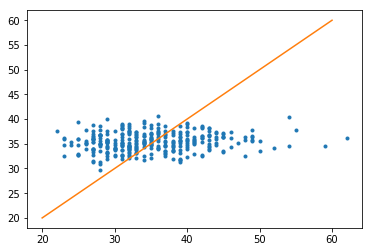

In [74]:
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(pca_df[pca_cols], pca_df['result_gamelength'], test_size=0.2, random_state=42)

model = LinearRegression()
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score
print(model.score(X_test, y_test))


# plot prediction and actual data
y_pred = model.predict(X_test) 
plt.plot(y_test, y_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(20, 60, 40)
y = x
plt.plot(x, y)
plt.show()

0.003110827515002801


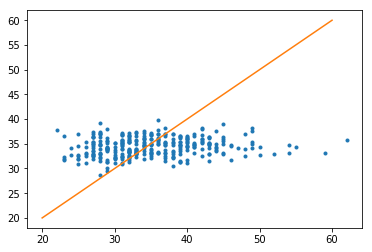

In [84]:
from sklearn.svm import SVR


X_train, X_test, y_train, y_test = train_test_split(pca_df[pca_cols], pca_df['result_gamelength'], test_size=0.2, random_state=42)

model = SVR(gamma=0.01, C=2.0, epsilon=0.01)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))


# plot prediction and actual data
y_pred = model.predict(X_test) 
plt.plot(y_test, y_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(20, 60, 40)
y = x
plt.plot(x, y)
plt.show() 

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

C = [0.25,0.5, 1, 2, 4]
gamma = [0.0001,0.001,0.01,0.1,0.5,1.0,10]
epsilon = [0.001,0.01, 0.1, 1.0, 10, 100]
kernel = ['rbf']
#degree = [3,4,5]
grid_params = {'C': C,
               'epsilon' : epsilon,
               'gamma': gamma,
              'kernel': kernel}

#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Use the random grid to search for best hyperparameters
# First create the base model to tune

model = SVR()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid = GridSearchCV(model, param_grid=grid_params, cv=5)


grid.fit(X_train, y_train)

print("the best parameters are %s with a score of %0.3f" %(grid.best_params_, grid.best_score_))

the best parameters are {'C': 2, 'epsilon': 0.001, 'gamma': 0.01, 'kernel': 'rbf'} with a score of 0.015


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


length of features normalized: 1
0.016396896044577725


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


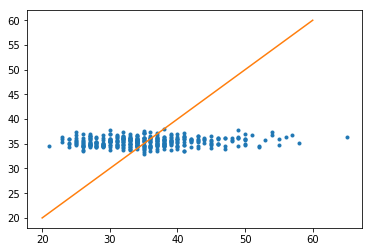

In [93]:
features = ['ave_gamelength']
target = 'result_gamelength'


df = prepare_dataset(vers,features=features,normalize=True)
X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score
print(model.score(X_test, y_test))


# plot prediction and actual data
y_pred = model.predict(X_test) 
plt.plot(y_test, y_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(20, 60, 40)
y = x
plt.plot(x, y)
plt.show()



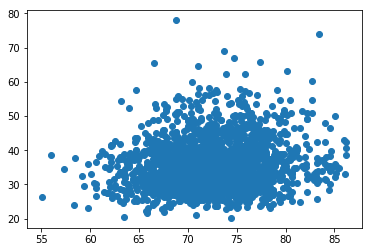

In [96]:
plt.scatter(vers['ave_gamelength'],vers['result_gamelength'])
plt.show()


In [97]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn import preprocessing


features = return_candidate_features(vers)


df = prepare_dataset(vers,features=features,normalize=True)
X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=20, step=1)
rfe.fit(X_train, y_train)
ranking = rfe.ranking_

print(ranking)

_ = np.where(ranking == 1)

best_feats = list(np.array(train_feats)[_])
print(best_feats)

model = model.fit(X_train[best_feats],y_train)
print(model.score(X_test[best_feats], y_test))

index   False
matchupWeek   False
week   True
date   True
game   True
matchID   True
split   False
gameid   True
gameid2   False
game_num   False
excluded:
 ADC_elo                 False
Jungle_elo              False
Middle_elo              False
Support_elo             False
Top_elo                 False
a                       False
airdrakes               False
ave_gamelength          False
ckpm                    False
csat10                   True
csat15                   True
csdat10                  True
csdat15                  True
cspm                    False
cssharepost15            True
d                       False
dmgtochamps             False
dmgtochampsperminute    False
draft_score             False
earnedgpm               False
earthdrakes             False
elders                  False
elementals              False
elo                     False
fbaron                  False
fbarontime              False
fbassist                 True
fdtime                  False
fir

ValueError: operands could not be broadcast together with shapes (93,) (2,) 